<a href="https://colab.research.google.com/github/anilsah895/skin_diseases_detection/blob/master/REsearch_Using_a_pre_trained_convnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
from google.colab import drive
drive.mount('/content/gdrive/')

Base_dir="gdrive/My Drive/Skin_Data1/"#content/gdrive/My Drive/Colab Notebooks/Skin_Data1
train_path = Base_dir+"train"
validation_path = Base_dir+"validation"

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [0]:
from keras import models
from keras import layers
from keras import optimizers
from keras.applications import VGG16
#local_weights_file = "gdrive/My Drive/skindata/vgg16_weights_tf_dim_ordering_tf_kernels.h5"

pre_trained_model = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

#pre_trained_model.load_weights(local_weights_file)
for layer in pre_trained_model.layers[:11]:
  layer.trainable = False
  
  
# Print the model summary
pre_trained_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [0]:
#conv_base.summary()
with open(Base_dir+"MODEL_SUMMARY_FILE.text","w") as fh:
    pre_trained_model.summary(print_fn=lambda line: fh.write(line + "\n"))

In [0]:
# Check the trainable status of the individual layers
for layer in pre_trained_model.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f5ad07cccf8> False
<keras.layers.convolutional.Conv2D object at 0x7f5ad07ccdd8> False
<keras.layers.convolutional.Conv2D object at 0x7f5ad07ccfd0> False
<keras.layers.pooling.MaxPooling2D object at 0x7f5ad06aabe0> False
<keras.layers.convolutional.Conv2D object at 0x7f5ad0645dd8> False
<keras.layers.convolutional.Conv2D object at 0x7f5ad0670320> False
<keras.layers.pooling.MaxPooling2D object at 0x7f5ad060a320> False
<keras.layers.convolutional.Conv2D object at 0x7f5ad0670c18> False
<keras.layers.convolutional.Conv2D object at 0x7f5ad0638128> False
<keras.layers.convolutional.Conv2D object at 0x7f5ad05ce080> False
<keras.layers.pooling.MaxPooling2D object at 0x7f5ad05e7978> False
<keras.layers.convolutional.Conv2D object at 0x7f5ad05e7208> True
<keras.layers.convolutional.Conv2D object at 0x7f5ad0592470> True
<keras.layers.convolutional.Conv2D object at 0x7f5ad0592d68> True
<keras.layers.pooling.MaxPooling2D object at 0x7f5ad0544c88> Tr

In [0]:
import tensorflow as tf
# Define a Callback class that stops training once accuracy reaches 98.85%
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('acc')>0.9885):
      print("\nReached 98.85% accuracy so cancelling training!")
      self.model.stop_training = True

In [0]:
model = models.Sequential()
model.add(pre_trained_model)
#model.add(layers.Flatten())
#model.last_layer.output()
model.add(layers.Flatten())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))
#pre_trained_model.trainable = False

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_4 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 8192)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               4194816   
_________________________________________________________________
dense_9 (Dense)              (None, 10)                5130      
Total params: 18,914,634
Trainable params: 17,179,146
Non-trainable params: 1,735,488
_________________________________________________________________


In [0]:
#from keras import models
from keras.preprocessing.image import ImageDataGenerator
callback1=myCallback()

model.compile(optimizer = optimizers.RMSprop(lr=0.00003, rho=0.9, epsilon=1e-08, decay=0.00001), 
              loss = 'categorical_crossentropy', 
              metrics = ['acc'])
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      horizontal_flip=True,
      vertical_flip=True,
      fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)
# Change the batchsize according to your system RAM
train_batchsize = 64
val_batchsize = 32
 
train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=(150, 150),
        batch_size=train_batchsize,
        class_mode='categorical')
 
validation_generator = validation_datagen.flow_from_directory(
        validation_path,
        target_size=(150, 150),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)


history = model.fit_generator(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=1,
callbacks=[callback1])

W0708 13:22:43.222975 140029654636416 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



Found 4400 images belonging to 10 classes.
Found 1100 images belonging to 10 classes.


W0708 13:22:43.642152 140029654636416 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/100
69/68 [==============================] - 961s 14s/step - loss: 1.9590 - acc: 0.3092 - val_loss: 1.6382 - val_acc: 0.4245
Epoch 2/100
69/68 [==============================] - 49s 713ms/step - loss: 1.5998 - acc: 0.4525 - val_loss: 1.6975 - val_acc: 0.4182
Epoch 3/100
69/68 [==============================] - 52s 751ms/step - loss: 1.4336 - acc: 0.5137 - val_loss: 1.4769 - val_acc: 0.5082
Epoch 4/100
69/68 [==============================] - 52s 749ms/step - loss: 1.3199 - acc: 0.5450 - val_loss: 1.4203 - val_acc: 0.5355
Epoch 5/100
69/68 [==============================] - 52s 755ms/step - loss: 1.2415 - acc: 0.5762 - val_loss: 1.2851 - val_acc: 0.5682
Epoch 6/100
69/68 [==============================] - 52s 756ms/step - loss: 1.1649 - acc: 0.6064 - val_loss: 1.4303 - val_acc: 0.5145
Epoch 7/100
69/68 [==============================] - 52s 755ms/step - loss: 1.1100 - acc: 0.6186 - val_loss: 1.2473 - val_acc: 0.5555
Epoch 8/100
69/68 [==============================] - 52s 755ms/

In [0]:
model.save(Base_dir+'skin_net0100.hdf5')


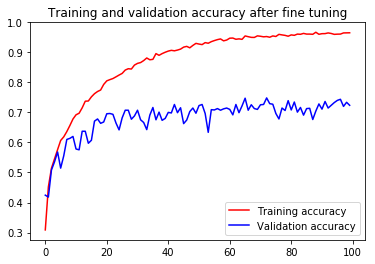

In [0]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy after fine tuning')
plt.legend(loc=0)
plt.savefig(Base_dir+"TRAINING_PLOT_FILE.png", bbox_inches='tight')
plt.savefig(Base_dir+"TRAINING_PLOT_FILE.png", bbox_inches='tight')

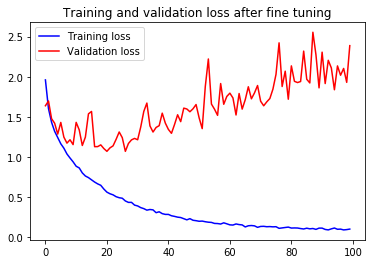

In [0]:
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss after fine tuning')
plt.legend()
plt.savefig(Base_dir+"VALIDATION_PLOT_FILE.png", bbox_inches='tight')
plt.savefig(Base_dir+"VALIDATION_PLOT_FILE.png", bbox_inches='tight')

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               4194816   
_________________________________________________________________
dense_4 (Dense)              (None, 10)                5130      
Total params: 18,914,634
Trainable params: 17,179,146
Non-trainable params: 1,735,488
_________________________________________________________________


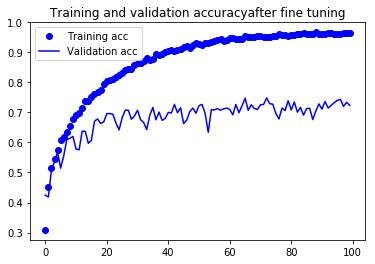

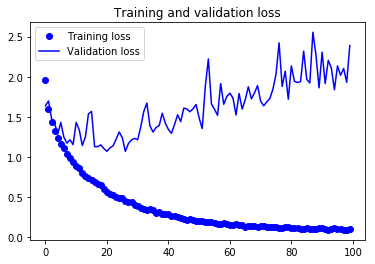

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracyafter fine tuning')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [0]:
pre_trained_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [0]:
pre_trained_model.trainable = True

set_trainable = False
for layer in pre_trained_model.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False



In [0]:
model.compile(optimizer = optimizers.RMSprop(lr=0.000003, rho=0.9, epsilon=1e-08, decay=0.00001), 
              loss = 'categorical_crossentropy', 
              metrics = ['acc'])

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               4194816   
_________________________________________________________________
dense_4 (Dense)              (None, 10)                5130      
Total params: 18,914,634
Trainable params: 11,279,370
Non-trainable params: 7,635,264
_________________________________________________________________


In [0]:
callback1=myCallback()
history = model.fit_generator(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size,
      epochs=50,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=1,
callbacks=[callback1])

Epoch 1/50
69/68 [==============================] - 55s 799ms/step - loss: 0.0752 - acc: 0.9681 - val_loss: 2.1046 - val_acc: 0.7382
Epoch 2/50
69/68 [==============================] - 50s 730ms/step - loss: 0.0489 - acc: 0.9786 - val_loss: 2.0869 - val_acc: 0.7409
Epoch 3/50
69/68 [==============================] - 51s 735ms/step - loss: 0.0482 - acc: 0.9771 - val_loss: 2.0838 - val_acc: 0.7400
Epoch 4/50
69/68 [==============================] - 51s 736ms/step - loss: 0.0404 - acc: 0.9820 - val_loss: 2.1497 - val_acc: 0.7427
Epoch 5/50
69/68 [==============================] - 50s 726ms/step - loss: 0.0438 - acc: 0.9792 - val_loss: 2.1204 - val_acc: 0.7409
Epoch 6/50
69/68 [==============================] - 50s 725ms/step - loss: 0.0343 - acc: 0.9830 - val_loss: 2.1434 - val_acc: 0.7409
Epoch 7/50
69/68 [==============================] - 50s 725ms/step - loss: 0.0285 - acc: 0.9862 - val_loss: 2.1711 - val_acc: 0.7445
Epoch 8/50
69/68 [==============================] - 50s 725ms/step - 

In [0]:
model.save(Base_dir+'skin_net_after_fineTuning50.hdf5')


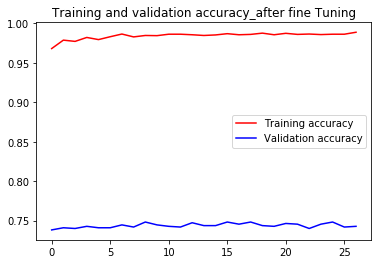

In [0]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy_after fine Tuning')
plt.legend(loc=0)
plt.savefig(Base_dir+"TRAINING_PLOT_FILE_after_fineTune.png", bbox_inches='tight')

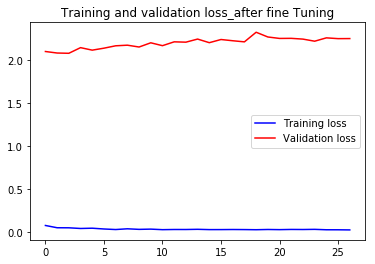

In [0]:
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss_after fine Tuning')
plt.legend()
plt.savefig(Base_dir+"VALIDATION_PLOT_FILE_with_finetune.png", bbox_inches='tight')

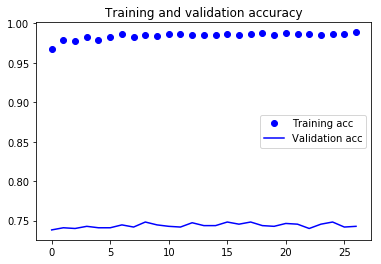

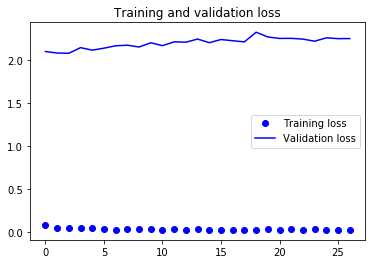

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Saving 12PeriungualWart.jpg to 12PeriungualWart.jpg
[1.8924947e-33 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 1.0000000e+00 0.0000000e+00]
The predicted disease found to be  Warts


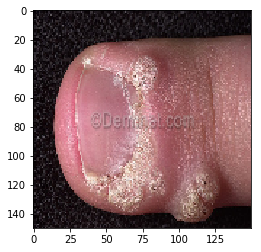

In [0]:
from keras.models import load_model
from google.colab import files
from keras.preprocessing import image
import numpy as np
from matplotlib.pyplot import imshow
from keras.applications.imagenet_utils import preprocess_input
import scipy.misc

model = load_model(Base_dir+'skin_net_after_fineTuning15.hdf5')
model.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['accuracy'])
CATEGORIES =["Acne-Rosacea", "Basal cell carcinoma"," Hair Loss Alopecia and other Hair Diseases",
             " Herpes"," Melanoma Skin Cancer Nevi and Moles",
            " Nail Fungus and other Nail Disease" , "Urticaria Hives"," Vasculitis"," Warts","seborrheic-keratoses"]
uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(150, 150))
  imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  #print('Input image shape:', x.shape)
  
  images = np.vstack([x])
  classes = model.predict(images)#, batch_size=10)
  #print(fn)
  
  print(classes[0])
  maximum=0.9
  for i,value in enumerate(classes[0]):
    if value>maximum:
      index=i
  print("The predicted disease found to be "+CATEGORIES[index]) 
  #print(type(CATEGORIES[int(classes[0][0])]))  
  
 

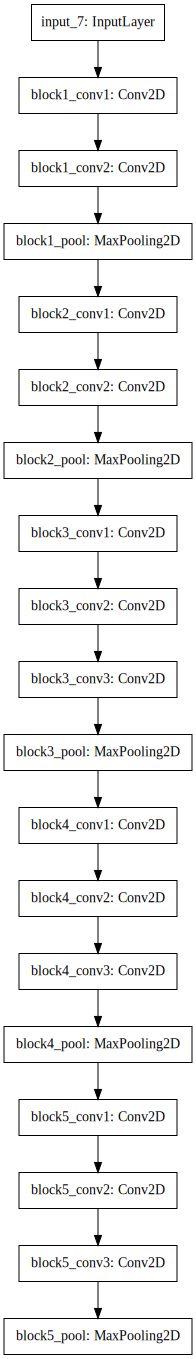

In [0]:
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
%matplotlib inline
plot_model(pre_trained_model, to_file=Base_dir+'model.png')
SVG(model_to_dot(pre_trained_model).create(prog='dot', format='svg'))


In [0]:
import cv2
import tensorflow as tf

CATEGORIES =["Acne-Rosacea", "Basal cell carcinoma"," Hair Loss Alopecia and other Hair Diseases",
             " Herpes"," Melanoma Skin Cancer Nevi and Moles",
            " Nail Fungus and other Nail Disease" , "Urticaria Hives"," Vasculitis"," Warts","seborrheic-keratoses"]
uploaded = files.upload()


def prepare(filepath):
    IMG_SIZE = 50  # 50 in txt-based
    img_array = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    return new_array.reshape(-1, IMG_SIZE, IMG_SIZE, 1)


model = tf.keras.models.load_model("64X3-Cnn.model")

prediction = model.predict([prepare('rash30.jpg')])
print(int(prediction))  # will be a list in a list.
print(CATEGORIES[int(prediction[0][0])])